<a href="https://colab.research.google.com/github/gutakeda/mvp-machine-learning-backend/blob/main/machine-learning/notebooks/Heart_Disease_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Notebook MVP Machine Learning
## Configuração do ambiente

In [39]:
# configuração para não exibir os warnings - editing
import warnings
warnings.filterwarnings("ignore")

# Imports necessários
import json
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# Função para verificar se está no Google Colab
def in_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False



## Carga do Dataset

O objetivo é classificar ou prever se um paciente está propenso à insuficiência cardíaca com base em múltiplos atributos.
Trata-se de uma classificação binária com diversas características numéricas e categóricas. O conjunto de dados inclui variáveis como idade, sexo, tipo de dor no peito, pressão arterial, colesterol, e outros indicadores médicos.
A coluna final, HeartDisease, indica se o paciente tem doença cardíaca (1) ou não (0),

Atributos:
- Age: idade do paciente (em anos)
- Sex: sexo do paciente (M: Masculino, F: Feminino)
- ChestPainType: tipo de dor no peito (TA: Angina Típica, ATA: Angina Atípica, NAP: Dor Não Anginosa, ASY: Assintomático)
- RestingBP: pressão arterial em repouso (mm Hg)
- Cholesterol: nível de colesterol sérico (mg/dl)
- FastingBS: açúcar no sangue em jejum (1: se > 120 mg/dl, 0: caso contrário)
- RestingECG: resultado do eletrocardiograma em repouso (Normal, ST: Anormalidade da onda ST-T, LVH: Hipertrofia ventricular esquerda)
- MaxHR: frequência cardíaca máxima atingida (valor numérico entre 60 e 202)
- ExerciseAngina: angina induzida por exercício (Y: Sim, N: Não)
- Oldpeak: valor de depressão ST
- ST_Slope: inclinação do segmento ST durante exercício (Up - Subindo, Flat - Plano, Down - Descendo)
- HeartDisease: classe de saída (1: doença cardíaca, 0: normal)

In [40]:
# Informa a URL de importação do dataset
url = "https://raw.githubusercontent.com/gutakeda/mvp-machine-learning-backend/main/machine-learning/data/heart.csv"

# Lê o arquivo
dataset = pd.read_csv(url, delimiter=',')

# Determinar se tem  nulos no dataset
missing_number = dataset.isnull().sum()
print(missing_number)
# Não há nulos no dataset

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64


In [41]:
# Cria um dicionário para armazenar os mapeamentos
mapping_dict = {}

# Aplica LabelEncoder a cada coluna categórica
for column in dataset.columns:
    if dataset[column].dtype == 'object':  # Verifica se a coluna é categórica
        le = LabelEncoder()
        dataset[column] = le.fit_transform(dataset[column])
        # Converte os valores do mapeamento para int
        mapping_dict[column] = {str(k): int(v) for k, v in zip(le.classes_, le.transform(le.classes_))}

# Salva o mapeamento em um arquivo json que será usado no backend
if not in_colab():
    with open('../../app/mapping_dict.json', 'w') as file:
        json.dump(mapping_dict, file, indent=4)
else:
    print("A parte de salvar o arquivo foi pulada no Google Colab.")

# Exibe o dataset transformado
dataset.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,1,140,289,0,1,172,0,0.0,2,0
1,49,0,2,160,180,0,1,156,0,1.0,1,1
2,37,1,1,130,283,0,2,98,0,0.0,2,0
3,48,0,0,138,214,0,1,108,1,1.5,1,1
4,54,1,2,150,195,0,1,122,0,0.0,2,0


## Análises de correlação

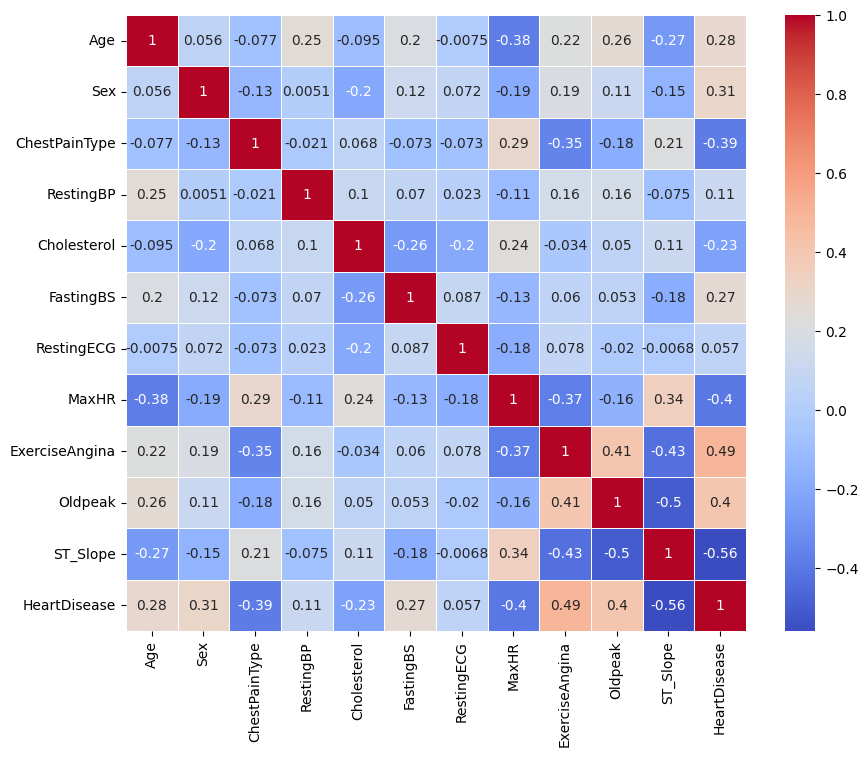

In [42]:
# Calcula a matriz de correlação
corr = dataset.corr()

# Configura o tamanho do gráfico
plt.figure(figsize=(10, 8))

# Gera o heatmap
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5)

# Exibe o gráfico
plt.show()

<Axes: >

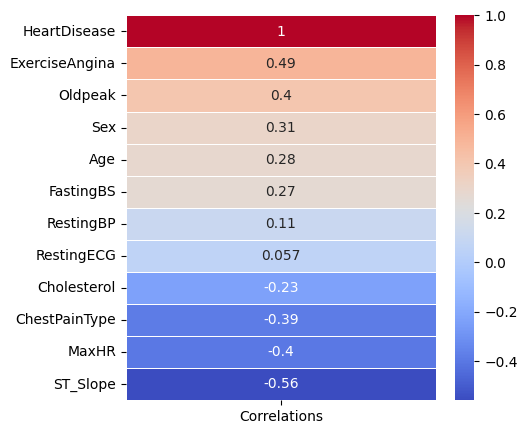

In [43]:
# Agora o heatmap com foco no HeartDisease
corr = dataset.corrwith(dataset['HeartDisease']).sort_values(ascending = False).to_frame()
corr.columns = ['Correlations']
plt.subplots(figsize = (5,5))
sns.heatmap(corr,annot = True,cmap = 'coolwarm',linewidths = 0.5)

Análises de correlação com HeartDisease:

- A variável ExerciseAngina tem uma correlação positiva moderada com HeartDisease (0.53). Isso indica que pessoas que experimentam angina durante o exercício têm maior probabilidade de desenvolver doenças cardíacas.
- ST_Slope tem uma correlação negativa com HeartDisease (-0.36). Uma inclinação descendente do segmento ST no ECG pode estar associada a maiores chances de doença cardíaca.
- Oldpeak também tem uma correlação positiva com HeartDisease (0.47), sugerindo que uma depressão do ST segment é um possível indicador de problemas cardíacos.
- MaxHR tem uma correlação negativa moderada com HeartDisease (-0.44), sugerindo que uma frequência cardíaca máxima mais baixa durante o exercício pode estar associada a uma maior probabilidade de doenças cardíacas.
- ChestPainType apresenta uma correlação negativa (-0.45), o que indica que tipos específicos de dor no peito podem ser mais frequentes em pessoas sem doenças cardíacas.

Apesar de Cholesterol e RestingECG apresentarem valores baixo de correlação com HeartDisease, resolvi mantê-las e treinar o modelo com todas as variáveis. Caso o modelo não apresente um índice de acurácia bom, poderemos no futuro criar novos modelos removendo essas variáveis e comparando com o resultado anterior.

## Separação em conjunto de treino e conjunto de teste com holdout

In [44]:
validation_size = 0.20  # 20% do dataset para o conjunto de validação (dados não vistos)
test_size = 0.25  # 25% do conjunto de treino será separado para teste (equivale a 20% do total)
seed = 7  # Semente aleatória

array = dataset.values
X = array[:,0:11]
y = array[:,11]

# Separação inicial: treino e validação
X_train_initial, X_val, y_train_initial, y_val = train_test_split(X, y,
    test_size=validation_size, shuffle=True, random_state=seed, stratify=y)

# Separação subsequente: treino e teste (a partir do conjunto de treino)
X_train, X_test, y_train, y_test = train_test_split(X_train_initial, y_train_initial,
    test_size=test_size, shuffle=True, random_state=seed, stratify=y_train_initial)

# Parâmetros e partições da validação cruzada
scoring = 'accuracy'
num_particoes = 10
kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=seed) # validação cruzada com estratificação

## Modelagem e Inferência

### Criação e avaliação de modelos: linha base

KNN: 0.696364 (0.029374)
CART: 0.796364 (0.056217)
NB: 0.841818 (0.052727)
SVM: 0.721818 (0.049493)


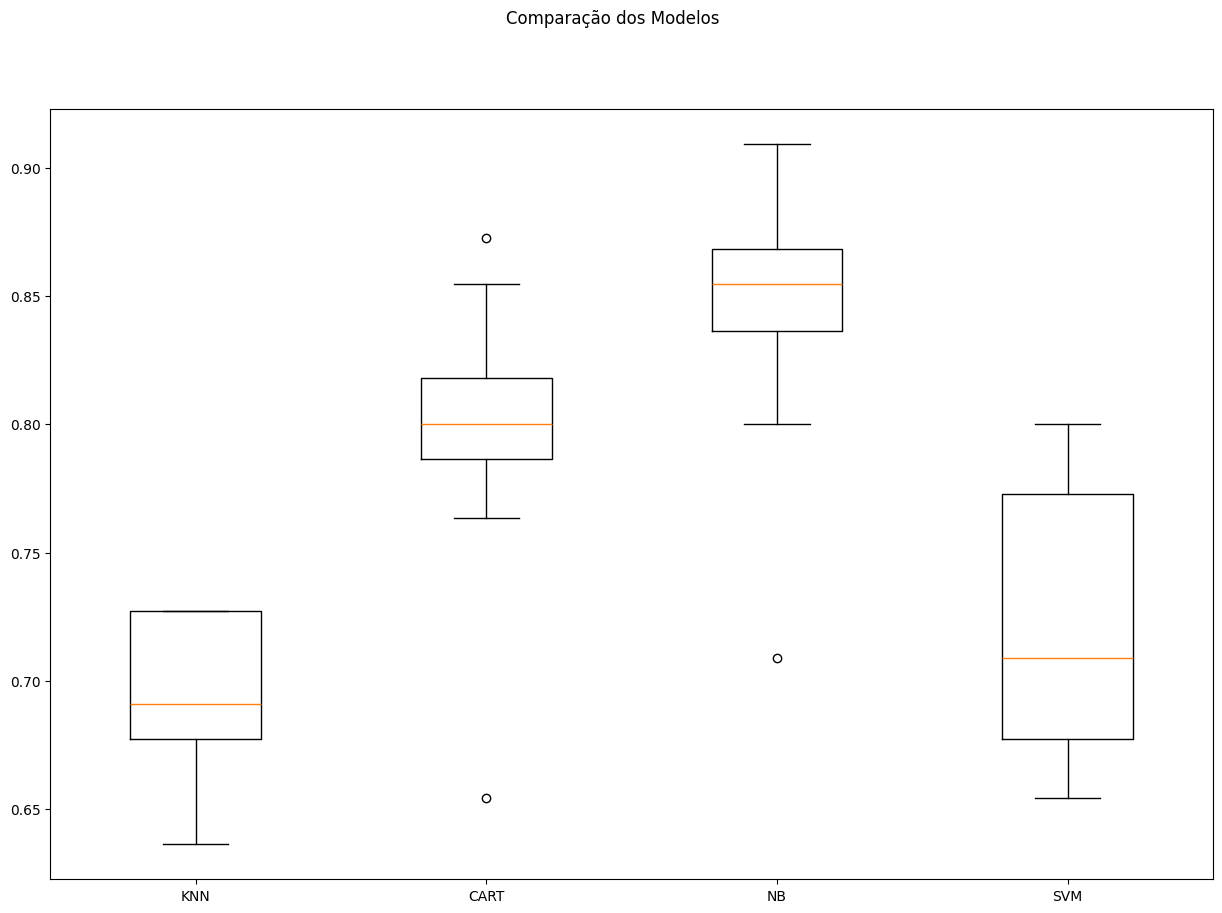

In [45]:
np.random.seed(7) # definindo uma semente global

# Lista que armazenará os modelos
models = []

# Criando os modelos e adicionando-os na lista de modelos
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

# Listas para armazenar os resultados
results = []
names = []

# Avaliação dos modelos
for name, model in models:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(15,10))
fig.suptitle('Comparação dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

### Criação e avaliação de modelos: dados padronizados e normalizados

KNN-orig: 0.696 (0.029)
CART-orig: 0.796 (0.056)
NB-orig: 0.842 (0.053)
SVM-orig: 0.722 (0.049)
KNN-padr: 0.851 (0.040)
CART-padr: 0.787 (0.053)
NB-padr: 0.842 (0.053)
SVM-padr: 0.856 (0.031)
KNN-norm: 0.862 (0.043)
CART-norm: 0.787 (0.051)
NB-norm: 0.842 (0.053)
SVM-norm: 0.853 (0.045)


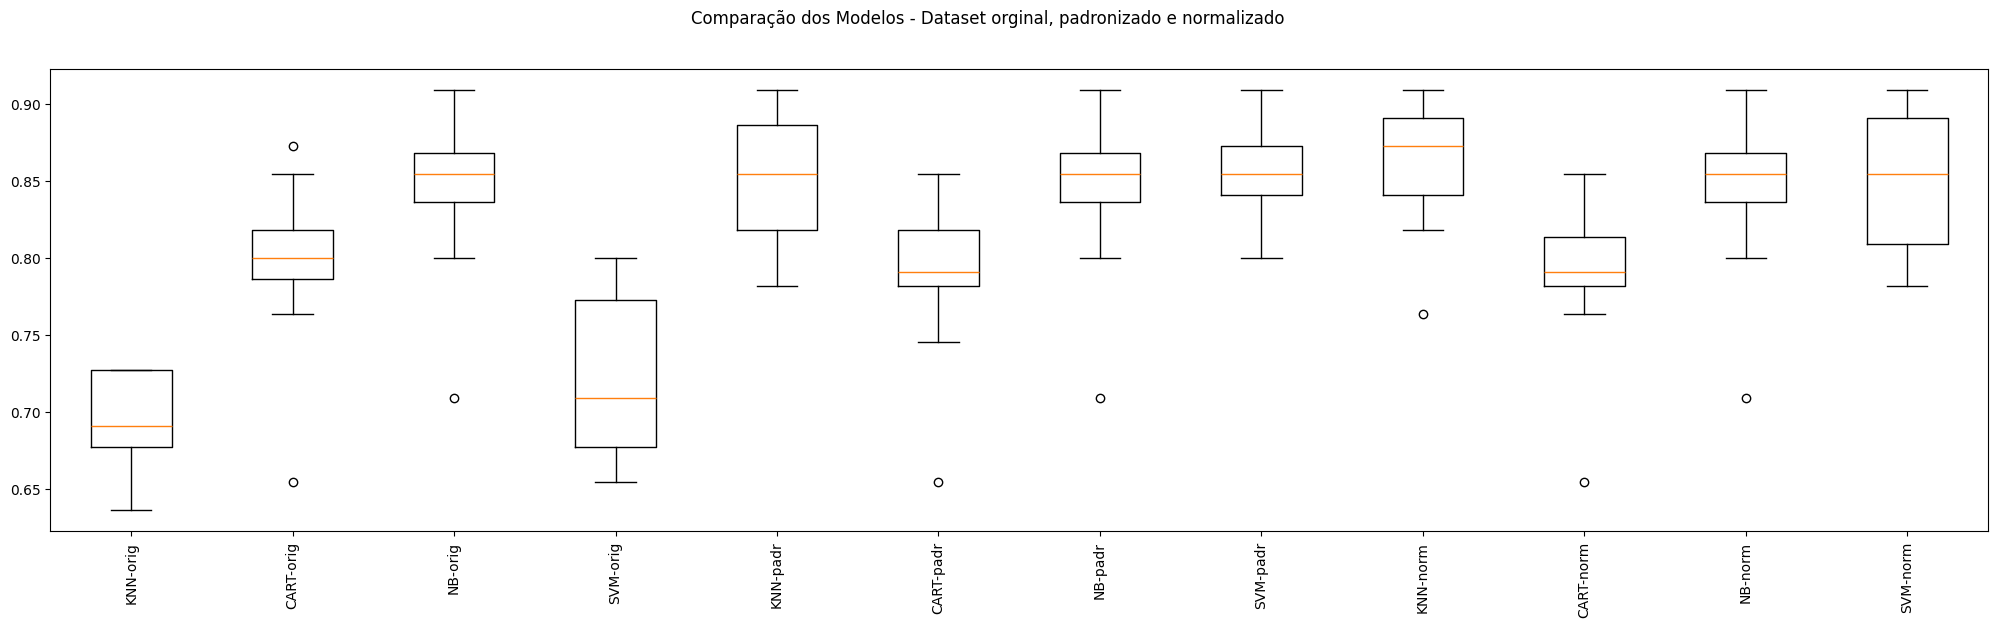

In [46]:
np.random.seed(7) # definindo uma semente global para este bloco

# Listas para armazenar os armazenar os pipelines e os resultados para todas as visões do dataset
pipelines = []
results = []
names = []


# Criando os elementos do pipeline

# Algoritmos que serão utilizados
knn = ('KNN', KNeighborsClassifier())
cart = ('CART', DecisionTreeClassifier())
naive_bayes = ('NB', GaussianNB())
svm = ('SVM', SVC())

# Transformações que serão utilizadas
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())


# Montando os pipelines

# Dataset original
pipelines.append(('KNN-orig', Pipeline([knn])))
pipelines.append(('CART-orig', Pipeline([cart])))
pipelines.append(('NB-orig', Pipeline([naive_bayes])))
pipelines.append(('SVM-orig', Pipeline([svm])))

# Dataset Padronizado
pipelines.append(('KNN-padr', Pipeline([standard_scaler, knn])))
pipelines.append(('CART-padr', Pipeline([standard_scaler, cart])))
pipelines.append(('NB-padr', Pipeline([standard_scaler, naive_bayes])))
pipelines.append(('SVM-padr', Pipeline([standard_scaler, svm])))

# Dataset Normalizado
pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
pipelines.append(('CART-norm', Pipeline([min_max_scaler, cart])))
pipelines.append(('NB-norm', Pipeline([min_max_scaler, naive_bayes])))
pipelines.append(('SVM-norm', Pipeline([min_max_scaler, svm])))

# Executando os pipelines
for name, model in pipelines:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std()) # formatando para 3 casas decimais
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(25,6))
fig.suptitle('Comparação dos Modelos - Dataset orginal, padronizado e normalizado')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=90)
plt.show()

### Otimização dos hiperparâmetros

In [47]:
np.random.seed(7) # definindo uma semente global para este bloco

# Tuning do KNN
knn_pipelines = []

# Definindo os componentes do pipeline
knn_pipelines.append(('KNN-orig', Pipeline(steps=[knn])))
knn_pipelines.append(('KNN-padr', Pipeline(steps=[standard_scaler, knn])))
knn_pipelines.append(('KNN-norm', Pipeline(steps=[min_max_scaler, knn])))

param_grid = {
    'KNN__n_neighbors': [1,3,5,7,9,11,13,15,17,19,21],
    'KNN__metric': ["euclidean", "manhattan", "minkowski"],
}

# Prepara e executa o GridSearchCV
for name, model in knn_pipelines:
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
    grid.fit(X_train, y_train)
    # imprime a melhor configuração
    print("%s - Melhor: %f usando %s" % (name, grid.best_score_, grid.best_params_))


# Tunning do SVM
svm_pipelines = []

svm_pipelines.append(('SVM-orig', Pipeline(steps=[svm])))
svm_pipelines.append(('SVM-padr', Pipeline(steps=[standard_scaler, svm])))
svm_pipelines.append(('SVM-norm', Pipeline(steps=[min_max_scaler, svm])))


# Reduzi os parametros do pro SVM abaixo para rodar mais rapidamente com o GridSearchCV
""" param_grid_svm = {
    'SVM__C': [0.1, 1, 10, 100],
    'SVM__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'SVM__gamma': ['scale', 'auto'],  # Parâmetro de kernel rbf, poly e sigmoid
    'SVM__degree': [2, 3, 4],  # Grau do polinômio se kernel for poly
} """

# Parâmetros a serem ajustados no SVM
param_grid_svm = {'SVM__C': [0.1, 1, 10],
'SVM__kernel': ['linear', 'rbf'],
'SVM__gamma': ['scale'],
}

# Executando o GridSearchCV para SVM
for name, model in svm_pipelines:
    grid = GridSearchCV(estimator=model, param_grid=param_grid_svm, scoring=scoring, cv=kfold)
    grid.fit(X_train, y_train)
    print("%s - Melhor: %f usando %s" % (name, grid.best_score_, grid.best_params_))

# Tunning do NB
nb_pipelines = []
nb_pipelines.append(('NB-orig', Pipeline(steps=[naive_bayes])))
nb_pipelines.append(('NB-padr', Pipeline(steps=[standard_scaler, naive_bayes])))
nb_pipelines.append(('NB-norm', Pipeline(steps=[min_max_scaler, naive_bayes])))

param_grid_nb = {
    'NB__var_smoothing': np.logspace(0, -9, num=100)
}

for name, model in nb_pipelines:
    grid = GridSearchCV(estimator=model, param_grid=param_grid_nb, scoring=scoring, cv=kfold)
    grid.fit(X_train, y_train)
    print("%s - Melhor: %f usando %s" % (name, grid.best_score_, grid.best_params_))

# Tunning do CART
cart_pipelines = []
cart_pipelines.append(('CART-orig', Pipeline(steps=[cart])))
cart_pipelines.append(('CART-padr', Pipeline(steps=[standard_scaler, cart])))
cart_pipelines.append(('CART-norm', Pipeline(steps=[min_max_scaler, cart])))

param_grid_cart = {
    'CART__max_depth': [None, 10, 20, 30, 40],
    'CART__min_samples_split': [2, 10, 20],
    'CART__min_samples_leaf': [1, 5, 10],
    'CART__criterion': ['gini', 'entropy']  # Função para medir a qualidade da divisão
}

for name, model in cart_pipelines:
    grid = GridSearchCV(estimator=model, param_grid=param_grid_cart, scoring=scoring, cv=kfold)
    grid.fit(X_train, y_train)
    print("%s - Melhor: %f usando %s" % (name, grid.best_score_, grid.best_params_))

# Rodou em 1m 43.3s local
# Rodou em 4m no Google Collab

# Resultados
# KNN-orig - Melhor: 0.747273 usando {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 13}
# KNN-padr - Melhor: 0.869091 usando {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 11}
# KNN-norm - Melhor: 0.870909 usando {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 5}
# SVM-orig - Melhor: 0.850909 usando {'SVM__C': 10, 'SVM__gamma': 'scale', 'SVM__kernel': 'linear'}
# SVM-padr - Melhor: 0.856364 usando {'SVM__C': 1, 'SVM__gamma': 'scale', 'SVM__kernel': 'rbf'}
# SVM-norm - Melhor: 0.852727 usando {'SVM__C': 1, 'SVM__gamma': 'scale', 'SVM__kernel': 'rbf'}
# NB-orig - Melhor: 0.847273 usando {'NB__var_smoothing': np.float64(6.579332246575683e-06)}
# NB-padr - Melhor: 0.845455 usando {'NB__var_smoothing': np.float64(0.12328467394420659)}
# NB-norm - Melhor: 0.843636 usando {'NB__var_smoothing': np.float64(0.01873817422860384)}
# CART-orig - Melhor: 0.838182 usando {'CART__criterion': 'entropy', 'CART__max_depth': 10, 'CART__min_samples_leaf': 1, 'CART__min_samples_split': 20}
# CART-padr - Melhor: 0.836364 usando {'CART__criterion': 'gini', 'CART__max_depth': None, 'CART__min_samples_leaf': 5, 'CART__min_samples_split': 20}
# CART-norm - Melhor: 0.836364 usando {'CART__criterion': 'gini', 'CART__max_depth': 20, 'CART__min_samples_leaf': 5, 'CART__min_samples_split': 20}

KNN-orig - Melhor: 0.747273 usando {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 13}
KNN-padr - Melhor: 0.869091 usando {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 11}
KNN-norm - Melhor: 0.870909 usando {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 5}
SVM-orig - Melhor: 0.850909 usando {'SVM__C': 10, 'SVM__gamma': 'scale', 'SVM__kernel': 'linear'}
SVM-padr - Melhor: 0.856364 usando {'SVM__C': 1, 'SVM__gamma': 'scale', 'SVM__kernel': 'rbf'}
SVM-norm - Melhor: 0.852727 usando {'SVM__C': 1, 'SVM__gamma': 'scale', 'SVM__kernel': 'rbf'}
NB-orig - Melhor: 0.847273 usando {'NB__var_smoothing': np.float64(6.579332246575683e-06)}
NB-padr - Melhor: 0.845455 usando {'NB__var_smoothing': np.float64(0.12328467394420659)}
NB-norm - Melhor: 0.843636 usando {'NB__var_smoothing': np.float64(0.01873817422860384)}
CART-orig - Melhor: 0.838182 usando {'CART__criterion': 'entropy', 'CART__max_depth': 10, 'CART__min_samples_leaf': 1, 'CART__min_samples_split': 20}
CART-padr - Melhor: 0.836364 usa

## Finalização dos Pipelines

KNN-norm: 0.870909 (0.040)
KNN-padr: 0.869091 (0.041)
SVM-padr: 0.856364 (0.031)


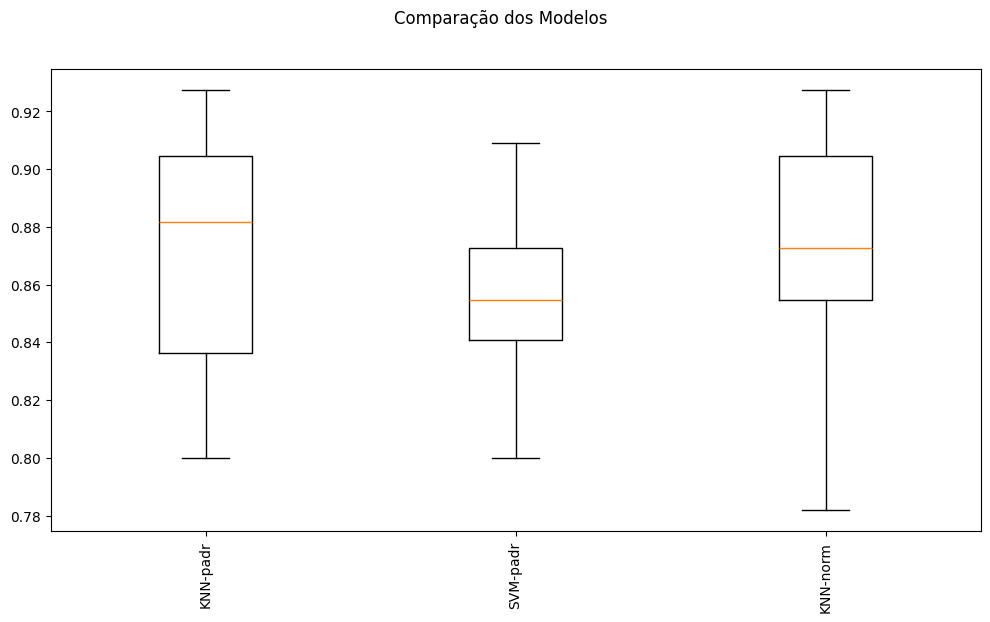

In [48]:
np.random.seed(7) # definindo uma semente global para este bloco

# Listas para armazenar os armazenar os pipelines e os resultados para todas as visões do dataset
pipelines = []
results = []
names = []

# Algoritmos com melhores parametros achamos pelo GridSearchCV no bloco anterior
# KNN-norm - Melhor: 0.870909 usando {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 5}
# KNN-padr - Melhor: 0.869091 usando {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 11}
# SVM-padr - Melhor: 0.856364 usando {'SVM__C': 1, 'SVM__gamma': 'scale', 'SVM__kernel': 'rbf'}

knn_norm = KNeighborsClassifier(n_neighbors=5, metric='manhattan')
knn_padr = KNeighborsClassifier(n_neighbors=11, metric='manhattan')
svm_padr = SVC(C=1, gamma='scale', kernel='rbf')

# Transformações que serão utilizadas
standard_scaler = StandardScaler()
min_max_scaler = MinMaxScaler()

pipeline_knn_norm = Pipeline([
    ('scaler', min_max_scaler),
    ('knn', knn_norm)
])

pipeline_knn_padr = Pipeline([
    ('scaler', standard_scaler),
    ('knn', knn_padr)
])

pipeline_svm_padr = Pipeline([
    ('scaler', standard_scaler),
    ('svm', svm_padr)
])

# Ajustar os pipelines com os dados de treinamento
pipeline_knn_norm.fit(X_train, y_train)
pipeline_knn_padr.fit(X_train, y_train)
pipeline_svm_padr.fit(X_train, y_train)

# Avaliar os pipelines
cv_results_knn_norm = cross_val_score(pipeline_knn_norm, X_train, y_train, cv=kfold, scoring=scoring)
cv_results_knn_padr = cross_val_score(pipeline_knn_padr, X_train, y_train, cv=kfold, scoring=scoring)
cv_results_svm_padr = cross_val_score(pipeline_svm_padr, X_train, y_train, cv=kfold, scoring=scoring)


print("KNN-norm: %f (%.3f)" % (cv_results_knn_norm.mean(), cv_results_knn_norm.std()))
print("KNN-padr: %f (%.3f)" % (cv_results_knn_padr.mean(), cv_results_knn_padr.std()))
print("SVM-padr: %f (%.3f)" % (cv_results_svm_padr.mean(), cv_results_svm_padr.std()))

# Comparação dos resultados com Boxplot
results = [cv_results_knn_padr, cv_results_svm_padr, cv_results_knn_norm]
names = ['KNN-padr', 'SVM-padr', 'KNN-norm']

fig = plt.figure(figsize=(12, 6))
fig.suptitle('Comparação dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=90)
plt.show()

In [49]:
# Avaliação do modelo com o conjunto de testes

# KNN - padr
predictions = pipeline_knn_padr.predict(X_test)
print(accuracy_score(y_test, predictions))

# KNN - norm
predictions = pipeline_knn_norm.predict(X_test)
print(accuracy_score(y_test, predictions))

# SVM - padr
predictions = pipeline_svm_padr.predict(X_test)
print(accuracy_score(y_test, predictions))



0.8804347826086957


0.8369565217391305
0.8858695652173914


## Salvando os Arquivos

In [50]:
# Salvar os pipelines com os melhores modelos
if not in_colab():
    with open("../pipelines/knn_padr.pkl", 'wb') as file:
        pickle.dump(pipeline_knn_padr, file)

    with open("../pipelines/svm_padr.pkl", 'wb') as file:
        pickle.dump(pipeline_svm_padr, file)

    with open("../pipelines/knn_norm.pkl", 'wb') as file:
        pickle.dump(pipeline_knn_norm, file)

    # Salvando X_test e y_test no mesmo arquivo test_dataset_heart_disease para teste
    X_test_df = pd.DataFrame(X_test, columns=dataset.columns[:-1])
    y_test_df = pd.DataFrame(y_test, columns=[dataset.columns[-1]])
    test_df =pd.concat([X_test_df, y_test_df], axis=1)
    test_df.to_csv("../data/test_dataset_heart_disease.csv", index=False)

    # Salvando X_val e y_val no mesmo arquivo val_dataset_heart_disease para validação
    X_val_df = pd.DataFrame(X_val, columns=dataset.columns[:-1])
    y_val_df = pd.DataFrame(y_val, columns=[dataset.columns[-1]])
    val_df = pd.concat([X_val_df, y_val_df], axis=1)
    val_df.to_csv("../data/val_dataset_heart_disease.csv", index=False)
print("A parte de salvar o arquivo foi pulada no Google Colab.")

A parte de salvar o arquivo foi pulada no Google Colab.


## Simulando a aplicação do modelo em dados não vistos

In [51]:
# Novos dados - não sabemos a classe!
data = {
    'age': [55.0, 52.0, 57.0, 64.0],
    'sex': [1.0, 1.0, 1.0, 1.0],
    'chest': [0.0, 0.0, 1.0, 0.0],
    'rest': [160.0, 128.0, 154.0, 120.0],
    'cholesterol': [289.0, 255.0, 232.0, 246.0],
    'fasting': [0.0, 0.0, 0.0, 0.0],
    'resting': [0.0, 1.0, 0.0, 0.0],
    'max': [145.0, 161.0, 164.0, 96.0],
    'exercise': [1.0, 1.0, 0.0, 1.0],
    'oldpeak': [0.8, 0.0, 0.0, 2.2],
    'stslope': [1.0, 2.0, 2.0, 0.0],
}


atributos = ['age', 'sex', 'chest', 'rest', 'cholesterol', 'fasting', 'resting', 'max', 'exercise', 'oldpeak', 'stslope']
entrada = pd.DataFrame(data, columns=atributos)

array_entrada = entrada.values
X_entrada = array_entrada[:,0:11].astype(float)

print(X_entrada)

[[ 55.    1.    0.  160.  289.    0.    0.  145.    1.    0.8   1. ]
 [ 52.    1.    0.  128.  255.    0.    1.  161.    1.    0.    2. ]
 [ 57.    1.    1.  154.  232.    0.    0.  164.    0.    0.    2. ]
 [ 64.    1.    0.  120.  246.    0.    0.   96.    1.    2.2   0. ]]


In [52]:
# Predição de classes dos dados de entrada utilizando
# Pipeline do KNN - normalizado
saidas = pipeline_knn_norm.predict(X_entrada)
print(saidas)

[1. 1. 0. 1.]


## Conclusão

### Aspectos Gerais

Este notebook apresentou uma análise abrangente de um conjunto de dados de insuficiência cardíaca, abordando desde a carga e transformação dos dados até a criação, avaliação e otimização de modelos preditivos.

Os principais passos incluem:

- Pré-processamento dos dados: Foi aplicada a codificação de variáveis categóricas, com LabelEncoder, para transformá-las em valores numéricos. O dataset foi verificado quanto à presença de valores nulos e dividido em conjuntos de treino e validação usando a técnica de holdout com estratificação.

- Análises de correlação: A matriz de correlação revelou variáveis como ExerciseAngina e ST_Slope com correlações significativas em relação à presença de doença cardíaca. No entanto, todas as variáveis foram mantidas no modelo.

- Modelagem inicial: Quatro algoritmos foram testados (KNN, CART, Naive Bayes, e SVM) com o conjunto de dados original. Os resultados indicaram que o NB teve o melhor desempenho.

- Padronização e normalização: Foram criados pipelines para os mesmos modelos, aplicando transformações de padronização (StandardScaler) e normalização (MinMaxScaler). O KNN obteve os melhores resultados com o dataset normalizado, seguido do SVM com os dados padronizados.

- Otimização de hiperparâmetros: Usando GridSearchCV, foram ajustados os hiperparâmetros de KNN e SVM. Para o KNN, a métrica de distância "manhattan" e o número de vizinhos ideal foram determinados. No caso do SVM, o kernel rbf e o valor de C=1 com gamma='scale' foram os parâmetros que proporcionaram o melhor desempenho. Após essa etapa o KNN com os dados normalizado e o KNN com os dados padronizados tiveram os melhores resultados seguido do SVM com os dados padronizados.

### Modelo escolhido

O modelo escolhido com o melhor desempenho foi o KNN normalizado

As etapas do processo para o KNN normalizado foram as seguintes:

- Normalização dos dados: Utilizamos o MinMaxScaler, que transformou os valores das variáveis de entrada para o intervalo entre 0 e 1, o que é fundamental para melhorar o desempenho de algoritmos baseados em distância, como o KNN.

- Configuração dos hiperparâmetros do KNN: O modelo foi configurado com:
n_neighbors = 5, ou seja, o algoritmo considera os 5 vizinhos mais próximos para classificar cada novo ponto.
Métrica de distância: Utilizou-se a distância de Manhattan, que calcula a soma das diferenças absolutas entre as coordenadas. Esta métrica mostrou-se mais adequada para o dataset em comparação com a distância Euclidiana.

- Validação do modelo: O desempenho foi avaliado através de validação cruzada, confirmando que o pipeline utilizando a normalização com MinMaxScaler e o KNN com distância de Manhattan foi a melhor combinação, alcançando bons resultados com os hiperparâmetros padrão.

Essa combinação simples e eficiente se mostrou a mais adequada, garantindo um bom desempenho e generalização.